In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from pymodulon.io import *
from os import path
import numpy as np
from matplotlib import cm
from matplotlib.colors import LogNorm
import mplcursors

interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))

/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' 

In [2]:
# look for iMs with largest changes
df = ica_data.sample_table
df = df[df['study'] == 'oxygen_shock']
df2 = pd.DataFrame(index = ica_data.A.index)#ica_data.A[df.index]
df2['var'] = ica_data.A[df.index].var(axis = 1)
df2['avg'] = ica_data.A[df.index].mean(axis = 1)
df2['range'] = ica_data.A[df.index].max(axis = 1) - ica_data.A[df.index].min(axis = 1)
df2.sort_values(by = ['var'], ascending = False).head()

,var,avg,range
translation_1,59.255845,-5.817718,23.837533
glycolysis_and_ATP_synthase,36.161316,-4.845301,20.630316
translation_2,23.350065,-3.261999,15.527334
oxidation_response_2,22.322948,5.055991,16.882215
SG_6,19.101919,4.491774,10.618069


anaerobic_t000
anaerobic_t000
anaerobic_t000


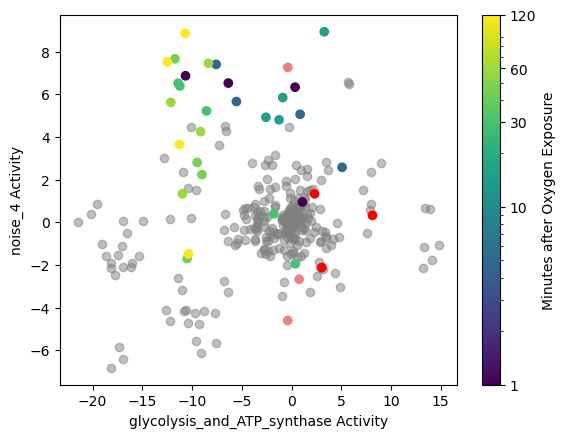

In [3]:
# settings
iM1 = 'glycolysis_and_ATP_synthase'
iM2 = 'noise_4'

if True:
    def int_to_color(value, X, Y, colormap='viridis'):
        if 'anaerobic' in value:
            if '60' in value:
                return 'red'
            else:
                return 'lightcoral'
        else:
            value = int(value.split('_t')[1])
        if value == 0:
            value = 0.1
        # Apply Log transformation to the value for coloring
        log_value = np.log10(value)  # Use log base 10 for the scale
        # Normalize the log-transformed value to the range [0, 1]
        normalized_value = (log_value - np.log10(X)) / (np.log10(Y) - np.log10(X))
        
        # Get the colormap
        cmap = plt.get_cmap(colormap)
        
        # Get the corresponding color (RGBA tuple)
        color = cmap(normalized_value)
        
        return color
    
    fig, ax = plt.subplots()
    
    # plotting scatter with colors
    highlight_samples = df.index
    other = list(set(ica_data.sample_table.index) - set(highlight_samples))
    scatter = ax.scatter(ica_data.A[other].loc[iM1], ica_data.A[other].loc[iM2], c='grey', alpha=0.5)
    
    # Get the colors for the highlighted samples using the logarithmic scaling
    colors = [int_to_color(value, 1, 120, 'viridis') for value in df.condition]
    
    # Create scatter plot with colors applied
    scatter2 = ax.scatter(ica_data.A[highlight_samples].loc[iM1], 
                           ica_data.A[highlight_samples].loc[iM2], 
                           c=colors)
    
    # Create the colorbar with a logarithmic normalization
    norm = LogNorm(vmin=1, vmax=120)  # LogNorm for the color scale
    
    cbar = plt.colorbar(cm.ScalarMappable(cmap='viridis', norm=norm), ax=ax, orientation='vertical')
    cbar.set_label('Minutes after Oxygen Exposure')
    
    # Set ticks for the colorbar (logarithmic scale)
    ticks = [1, 10, 30, 60, 120]  # Logarithmic ticks
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{int(t)}' for t in ticks])  # Integer tick labels
    
    # Label axes
    plt.xlabel(iM1 + ' Activity')
    plt.ylabel(iM2 + ' Activity')
    
    # Add interactive cursor for hovering
    cursor = mplcursors.cursor(scatter2, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(highlight_samples[sel.index])  # Show label for hovered point
    
    # Save and show
    plt.savefig('../figures/oxygen_response_iMs.pdf', transparent=True)
    plt.show()
